<a href="https://colab.research.google.com/github/salmonin-o3o/ESAA_study/blob/main/250310_markdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

핸즈온
## 4.5 규제가 있는 선형 모델
선형 회귀 모델에서는 보통 모델의 가중치를 제한함으로써 규제를 가한다.

### 4.5.1 릿지 회귀
규제항이 비용 함수에 추가된다. 이는 학습 알고리즘을 데이터에 맞추는 것뿐만 아니라 모델의 가중치가 가능한 한 작게 유지되도록 노력한다. alpha = 0이면 릿지 회귀는 선형 회귀와 같아지며, alpha가 아주 크면 모든 가중치가 거의 0에 가까워지고 결국 데이터의 평균을 지나는 수평선이 된다. alpha를 증가시킬수록 모델이 직선에 가까워진다. 즉, 모델의 분산은 줄지만 편향은 커지게 된다.

+) 릿지 회귀는 입력 특성의 스케일에 민감하기 때문에 수행하기 전에 데이터의 스케일을 맞추는 것이 중요하다.(StandardScaler) 규제가 있는 모델은 대부분 마찬가지.

선형 회귀와 마찬가지로 릿지 회귀를 계산하기 위해 정규방정식을 사용할 수도 있고 경사 하강법을 사용할 수도 있다. 다음은 사이킷런에서 정규방정식을 사용한 릿지 회귀를 적용하는 예이다.

In [1]:
import numpy as np

m = 100
X = 6 * np.random.randn(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

In [2]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([15.1734617])

In [3]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([12.61990801])

penalty 매개변수 사용할 규제를 지정한다. "l2"는 릿지 회귀와 같다.

### 4.5.2 라쏘 회귀
라쏘 회귀의 중요한 특징은 덜 중요한 특성의 가중치를 제거하려고 한다는 점이다. 다시 말해, 라쏘 회귀는 자동으로 특성 선택을 하고 희소 모델을 만든다.

+) 라쏘를 사용할 때 경사 하강법이 최적점 근처에서 진동하는 것을 막으려면 훈련하는 동안 점진적으로 학습률을 감소시켜야 한다.

+) 라쏘의 비용 함수는 theta=0에서 미분 가능하지 않다. 하지만 theta = 0일 때 서브그레이디언트 벡터를 사용하면 경사 하강법을 적용하는 데 문제가 없다.

In [4]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([15.18381212])

Lasso 대신 SGDRegressor(penalty="l1")을 사용할 수도 있다.

### 4.5.3 엘라스틱넷
엘라스틱넷은 릿지 회귀와 라쏘 회귀를 절충한 모델이다. 규제항은 릿지와 회귀의 규제항을 단순히 더해서 사용하며, 혼합 정도는 혼합 비율 r을 사용해 조절한다. r=0이면 엘라스틱넷은 릿지 회귀와 같고, r=1이면 라쏘 회귀와 같다.

적어도 규제가 약간 있는 것이 대부분의 경우에 좋으므로 일반적으로 평범한 선형 회귀는 피해야한다. 릿지가 기본이 되지만 쓰이는 특성이 몇 개뿐이라고 의심되면 라쏘나 엘라스틱넷이 낫다. 특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어 있을 때는 보통 라쏘가 문제를 일으키므로 라쏘보다는 엘라스틱넷을 선호한다.

다음은 사이킷런의 ElasticNet을 사용한 간단한 예이다.(l1_ratio가 혼합 비율 r이다.)

In [5]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([15.18579808])

### 4.5.4 조기 종료
경사 하강법과 같은 반복적인 학습 알고리즘을 규제하는 아주 색다른 방식은 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 것이다. 이를 조기 종료라고 한다.

In [6]:
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)

# 데이터 준비
poly_scaler = Pipeline([("poly_features", PolynomialFeatures(degree=90, include_bias=False)), ("std_scaler", StandardScaler())])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled,y_train.ravel()) # 훈련을 이어서 진행합니다.
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

## 4.6 로지스틱 회귀
어떤 회귀 알고리즘은 분류에서도 사용할 수 있습니다. 로지스틱 회귀는 샘플이 특정 클래스에 속할 확률을 추정하는 데 널리 사용된다. 추정 확률이 50%가 넘으면 모델은 그 샘플이 해당 클래스에 속한다고 예측하고(양성 클래스), 아니면 클래스에 속하지 않는다고 예측한다(음성 클래스). 이를 이진 분류기라고 한다.

### 4.6.1 확률 추정
로지스틱 회귀는 선형 회귀 모델과 같이 입력 특성의 가중치 합을 계산한다. 대신, 선형 회귀처럼 결과를 바로 출력하지 않고 결괏값의 로지스틱을 출력한다. 로지스틱은 0과 1 사이의 값을 출력하는 시그모이드 함수이다.

### 4.6.2 훈련과 비용 함수
로지스틱 회귀 모델의 훈련의 목적은 양성 샘플에 대해서는 높은 확률을 추정하고 음성 샘플에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터를 찾는 것이다.

전체 훈련 세트에 대한 비용 함수는 모든 훈련 샘플의 비용을 평균한 것이다. 이를 로그 손실이라고 부른다. 이 비용 함수의 최솟값을 계산하는 알려진 해가 없으므로(정규 방정식이 없음), 경사 하강법을 사용한다. 또한 모든 편도 함수를 포함한 그레이디언트 벡터를 만들면 배치 경사 하강법 알고리즘을 사용할 수 있다.

### 4.6.3 결정 경계
로지스틱 회귀를 설명하기 위해 붓꽃 데이터셋을 사용한다. 먼저, 꽃잎의 너비를 기반으로 Iris-Versicolor 종을 감지하는 분류기를 만들어보자.

In [7]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [8]:
X = iris["data"][:, 3:] # 꽃잎의 너비
y = (iris["target"] == 2).astype(int) # 1 Iris-Virginica면 1, 그렇지 않으면 0

In [9]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

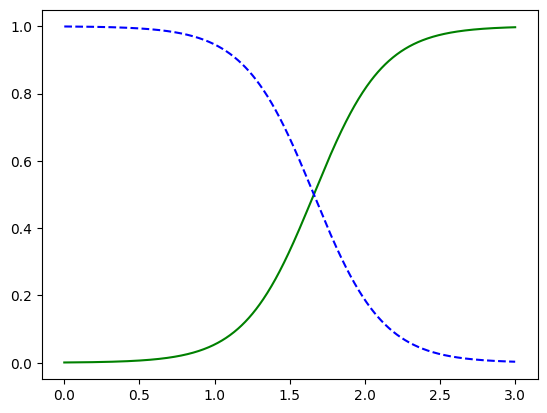

In [10]:
import matplotlib.pyplot as plt

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris virginica")
# 다음은 이미지를 미려하게 출력하기 위한 맷플롯립 코드가 이어집니다.

In [11]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

다른 선형 모델처럼 로지스틱 회귀 모델도 l1, l2 패널티를 사용하여 규제할 수 있다. 사이킷런은 l2를 기본으로 한다.

### 4.6.4 소프트맥스 회귀
로지스틱 회귀 모델은 여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화될 수 있다. 이를 소프트맥스 회귀 또는 다항 로지스틱 회귀라고 한다.

+) 소프트맥스 회귀 분류기는 한 번에 하나의 클래스만 예측한다. 그래서 종류가 다른 붓꽃 같이 상호 배타적인 클래스에서만 사용해야 한다. 하나의 사진에서 여러사람의 얼굴은 인식하는 데는 사용할 수 없다.

모델 훈련 방법
모델이 타깃 클래스에 대해서는 높은 확률을 추정하도록 만드는 것이 목적이다. 크로스 엔트로피는 추정된 클래스의 확률이 타깃 클래스에 얼마나 잘 맞는지 측정하는 용도로 종종 사용된다.

소프트맥스 회귀를 사용해 붓꽃을 세 개의 클래스로 분류해보자. 사이킷런의 LogisticRegression은 클래스가 둘 이상일 때 기본적으로 일대다 전략을 사용한다. 하지만 multi_class 매개변수를 "multinomial"로 바꾸면 소프트맥스 회귀를 사용할 수 있다.

In [12]:
X = iris["data"][:, (2, 3)] # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=10, multi_class='multinomial')

In [13]:
softmax_reg.predict([[5, 2]])

array([2])

In [14]:
softmax_reg.predict_proba([[5, 2]])

array([[6.21626375e-07, 5.73689803e-02, 9.42630398e-01]])